## Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=NoM6pZcMoxDfWa20LBi_K0TwTsJAY19tdcSwYN2y0Kk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgbCd19qJNcOPE_VFfhxtIYJ7sqSJvMiqDi3N5ePKvnLlWr9k7TCYI

Successfully saved authorization token.


In [2]:
!pip install geopandas
!pip install rioxarray
!pip install geojson
!pip install rasterstats
!pip install geemap

import os
from glob import glob
import numpy as np
import pandas as pd
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import geemap
#import gdal




## User-defined Functions

In [18]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [19]:
# Function to add water Index bands
def addIndex(image):
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [20]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [21]:
# Function of Otsu's Method
def thresholding(image):
  
  #waterIndex = index
  bands = ['ndwi', 'mndwi', 'awei', 'wiFi']

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  hist_ndwi = image.select([bands[-1]]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True)
  
  thrh_ndwi = otsu(hist_ndwi.get(bands[-1]+'_histogram'))

  #watermask_ndwi = image.select([bands[-1]]).gt(thrh_ndwi).rename(['watermask_'+bands[-1]]).selfMask()
  watermask_ndwi = image.select([bands[-1]]).gt(thrh_ndwi).rename(['watermask_'+bands[-1]]).unmask(2)
  # Water = 1, Non-water = 0, No-Data = 2

  return image.addBands([watermask_ndwi]) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [22]:
def thresholding2(image):
  #indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
  #indices = ['wiFi']
  indices = waterIndices

  histograms = [image.select([i]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True) for i in indices]

  thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,indices)]

  #watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).selfMask() for i,t in zip(indices,thrhs)]
  watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).unmask(2) for i,t in zip(indices,thrhs)]
  # Water = 1, Non-water = 0, No-Data = 2

  #.addBands([watermasks[0], watermasks[1], watermasks[2], watermasks[3]]) 
  return image.addBands(watermasks)\
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

## Load ROIs (parcel)

In [8]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), '*.geojson'))[0]
parcels = gpd.read_file(path_parcels)
parcels.head()

,GID_0,NAME_0,xcentroid,ycentroid,rep_val,id,geometry
0,BGD,Bangladesh,89.623393,21.990277,55.806835,0,"MULTIPOLYGON (((89.31118 20.35796, 89.07910 21..."
1,BGD,Bangladesh,91.655673,21.423706,56.539689,1,"MULTIPOLYGON (((93.22541 23.10278, 93.12052 22..."
2,BGD,Bangladesh,91.256547,23.116165,57.186356,2,"MULTIPOLYGON (((93.23961 23.12663, 93.22541 23..."
3,CHN,China,109.037387,17.696821,63.367104,3,"MULTIPOLYGON (((108.86237 18.67709, 109.55282 ..."
4,CHN,China,108.746733,19.332447,64.039590,4,"MULTIPOLYGON (((108.89992 19.99171, 110.11844 ..."


In [9]:
parcelID = range(len(parcels))
parcelID

range(0, 266)

In [10]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

## GEE: export water masks at parcel level

In [55]:
# Define roi

#roi = ee.Geometry.Polygon(
#        [[[99.28428353389887, 9.240779203282264],
#          [99.28428353389887, 9.12554558825899],
#          [99.43362893184809, 9.12554558825899],
#          [99.43362893184809, 9.240779203282264]]])
# TEST!!

roi = ee.Geometry(parcels_geojson['features'][parcelID[151]]['geometry'])
roi.getInfo()

{'coordinates': [[[124.360942, -2.437185],
   [126.685749, -2.514812],
   [126.227524, -1.216745],
   [125.732629, -0.650658],
   [123.714848, -1.288694],
   [124.360942, -2.437185]]],
 'type': 'Polygon'}

In [56]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(roi) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [57]:
# Temporally reduced at scale of one year
years = ee.List.sequence(1984, 2019)

ls_Treduced = ee.ImageCollection.fromImages(
    years.map(lambda YEAR: ls_all.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
                          .median() \
                          .clip(roi) \
                          .set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))

In [58]:
# Filter out years where no data are available
# Add "bandlength" as new property
ls_filtered = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
ls_filtered = ls_filtered.filterMetadata('bandlength', 'not_equals', 0)

In [59]:
# Apply Otsu
#waterIndices = ['ndwi', 'mndwi', 'awei', 'wiFi']
waterIndices = ['wiFi']

ls_wmsk = ls_filtered.map(thresholding2)
ls_wmsk = ls_wmsk.select(['watermask_'+i for i in waterIndices]).map(lambda image: image.toByte()) # Cast to uint-8bit 

#print(ls_wmsk.size().getInfo())
#print(ls_wmsk.first().bandNames().getInfo())
#print(ls_wmsk.first().bandTypes().getInfo())

In [60]:
Map = geemap.Map(center=(20, 110), zoom=3)
Map.addLayer(roi, {}, 'roi', False)
#Map.addLayer(ls_filtered.filter(ee.Filter.eq('year', 2019)), {'bands':['nir', 'red', 'green'], min:0, max:0.15}, 'FCC')
#Map.addLayer(ls_wmsk.filter(ee.Filter.eq('year', 2019)).select(['watermask_wiFi']), {'palette':['grey','blue','white']}, 'water mask awei 2019')
#Map.addLayer(ls_filtered.first(), {'bands':['nir', 'red', 'green'], min:0, max:0.15}, 'FCC')
Map.addLayer(ls_wmsk.first().select(['watermask_wiFi']), {'palette':['grey','blue','white'], 'min':0, 'max':2}, 'water mask awei first')
Map

Map(center=[20, 110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

In [61]:
#img_wmsk = ls_wmsk.toBands()
#task_config = {
#    'description': 'p151_wiFi',
#    'fileNamePrefix': 'p151_wiFi',
#    'crs': 'EPSG:4326',
#    'scale': 30,  
#    'region': roi.getInfo()['coordinates'],
#    'folder': 'myExportImage',
#    'skipEmptyTiles': True,
#    'fileFormat': 'GeoTIFF',
#    'maxPixels': 10e12
#    }
#task = ee.batch.Export.image.toDrive(img_wmsk, **task_config)
#task.start() 

In [62]:
#task.status()

## Post-processing in Python

### Merge Rasters in GDAL
* **Pro: Output Filesize can be compressed directly**
* https://gis.stackexchange.com/questions/2195/gdalmerge-produces-file-that-is-much-too-large
* (https://gdal.org/programs/gdal_merge.html?highlight=gdal_merge) & (https://gdal.org/drivers/raster/gtiff.html#creation-options)
* **Con: Band Names lost**

### Merge Rasters in Xarray
* https://corteva.github.io/rioxarray/stable/examples/convert_to_raster.html
* Merging datasets resulting in much larger file size: https://github.com/pydata/xarray/issues/1572
* **Pro: Band Names are kept**
* **Con: Much Larger Output Filesize, extra compression needed**

In [ ]:
from rioxarray.merge import merge_arrays

In [ ]:
path_img = '/content/drive/My Drive/myExportImage/parcels_msk_30m/original/'
items = glob(os.path.join(path_img, '*151*.tif'))
items

['/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p151_wiFi-0000000000-0000000000.tif',
 '/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p151_wiFi-0000000000-0000011008.tif']

In [ ]:
# Merge DataArrays
elements = [rioxr.open_rasterio(i) for i in items]
xda_merged = merge_arrays(elements)
xda_merged

<xarray.DataArray (band: 36, y: 4484, x: 11535)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 132.5 132.5 132.5 132.5 ... 135.6 135.6 135.6 135.6
  * y            (y) float64 35.29 35.29 35.29 35.29 ... 34.08 34.08 34.08 34.08
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('0_watermask_wiFi', '1_watermask_wiFi', '2_watermask_wiFi...

In [ ]:
# Write to Raster
xda_merged.rio.to_raster(os.path.join(path_img, 'p151_merged.tif'))

### Compress Raster Size
reference: https://gis.stackexchange.com/questions/345883/how-to-decrease-raster-file-size

In [ ]:
import gdal

In [ ]:
wdir = '/content/drive/My Drive/myExportImage/parcels_msk_30m'
infn = glob(os.path.join(wdir, 'original', '*merged.tif'))
print(infn)
oufn = [i.split('.')[0]+'_rdc.tif' for i in infn]
print(oufn)

['/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p151_merged.tif']
['/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p151_merged_rdc.tif']


In [ ]:
# (PREDICTOR) 2 for integer;
ds = [gdal.Translate(o,i,creationOptions=["COMPRESS=LZW", "TILED=YES", "PREDICTOR=2"]) for o,i in zip(oufn,infn)]
ds = None

### Tidy rasters

In [ ]:
# Pair up Index and Years
keys = [str(i) for i in range(36)]
#years = pd.date_range(start='1984', end='2020', freq='Y')
years = [i for i in range(1984,2020)]
pair = dict([[i,j] for i,j in zip(keys, years)])
print(pair)

{'0': 1984, '1': 1985, '2': 1986, '3': 1987, '4': 1988, '5': 1989, '6': 1990, '7': 1991, '8': 1992, '9': 1993, '10': 1994, '11': 1995, '12': 1996, '13': 1997, '14': 1998, '15': 1999, '16': 2000, '17': 2001, '18': 2002, '19': 2003, '20': 2004, '21': 2005, '22': 2006, '23': 2007, '24': 2008, '25': 2009, '26': 2010, '27': 2011, '28': 2012, '29': 2013, '30': 2014, '31': 2015, '32': 2016, '33': 2017, '34': 2018, '35': 2019}


In [ ]:
path_img = '/content/drive/My Drive/myExportImage/parcels_msk_30m/original/'
items = glob(os.path.join(path_img, '*11*.tif'))
items

['/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p_11_B.tif',
 '/content/drive/My Drive/myExportImage/parcels_msk_30m/original/p_11_A.tif']

In [ ]:
elements = [rioxr.open_rasterio(i) for i in items]
#xda = [i.rename({'band':'time'}) for i in elements]
#xds = [i.to_dataset(name="watermask") for i in xda]

xda = elements[1].rename({'band':'time'})
xds = xda.to_dataset(name='watermask')
xds = xds.reindex(y = list(reversed(xds.y)))
xds

<xarray.Dataset>
Dimensions:      (time: 34, x: 11264, y: 11264)
Coordinates:
  * y            (y) float64 21.59 21.59 21.59 21.59 ... 24.62 24.62 24.62 24.62
  * time         (time) int64 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 117.3 117.3 117.3 117.3
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

In [ ]:
# Get the index of loaded image
imgID = [i.split('_')[0] for i in xda.attrs['long_name']]
print(imgID)

# Get years based on index
t = [pair[i] for i in imgID]
print(t)

['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
[1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [ ]:
# Replace "index" coordinates with "year" coordinates
xds.coords['time'] = np.array(t)
xds

<xarray.Dataset>
Dimensions:      (time: 34, x: 11264, y: 11264)
Coordinates:
  * y            (y) float64 21.59 21.59 21.59 21.59 ... 24.62 24.62 24.62 24.62
  * time         (time) int64 1986 1987 1988 1989 1990 ... 2016 2017 2018 2019
  * x            (x) float64 114.3 114.3 114.3 114.3 ... 117.3 117.3 117.3 117.3
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

In [ ]:
# Map
#xds.watermask.sel(time=2019).plot()
#xds.watermask.plot(robust=True, col="time", col_wrap=3)

In [ ]:
# Write Raster
#xds.rio.to_raster(os.path.join(path_img, 'p100_mask_tidy.tif'))

## Annual Water Info -> Attributes of each pond

### Load Ponds at Country Level

In [ ]:
# Load Pond layer at Country Level
path_ponds = '/content/drive/My Drive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Aquaculture_ponds_Asian_coast_2019/ponds_by_country/pond_2019_China.gpkg'
# Load Ponds of one country
ponds_chn = gpd.read_file(path_ponds)
ponds_chn.head()

,id,index_right,GID_0,NAME_0,geometry
0,88102,2,CHN,China,"MULTIPOLYGON (((107.83880 21.64298, 107.83958 ..."
1,88108,2,CHN,China,"MULTIPOLYGON (((107.84574 21.64895, 107.84596 ..."
2,88115,2,CHN,China,"MULTIPOLYGON (((107.86251 21.61913, 107.86251 ..."
3,88323,2,CHN,China,"MULTIPOLYGON (((107.87904 21.63030, 107.87904 ..."
4,88326,2,CHN,China,"MULTIPOLYGON (((107.88012 21.62934, 107.88030 ..."


### Subset Ponds to Parcel Level
*After finishing the calculation of one parcel, delete that from RAM before subsetting the next parcel.*

In [ ]:
ponds_sub = ponds_chn[ponds_chn.geometry.within(parcels[parcels['id']==parcelID[11]].geometry.unary_union)]
ponds_sub

,id,index_right,GID_0,NAME_0,geometry
831974,885556,2,CHN,China,"MULTIPOLYGON (((115.85321 23.41926, 115.85321 ..."
831975,885557,2,CHN,China,"MULTIPOLYGON (((115.85482 23.42285, 115.85482 ..."
831976,885558,2,CHN,China,"MULTIPOLYGON (((115.85608 23.41037, 115.85653 ..."
831977,885559,2,CHN,China,"MULTIPOLYGON (((115.85707 23.41225, 115.85734 ..."
831978,885560,2,CHN,China,"MULTIPOLYGON (((115.85815 23.41046, 115.85815 ..."
...,...,...,...,...,...
885710,941218,2,CHN,China,"MULTIPOLYGON (((114.68297 22.92878, 114.68297 ..."
885712,941220,2,CHN,China,"MULTIPOLYGON (((114.68701 22.91782, 114.68710 ..."
885714,941222,2,CHN,China,"MULTIPOLYGON (((114.68836 22.91414, 114.68863 ..."
885748,941259,2,CHN,China,"MULTIPOLYGON (((114.74747 22.73456, 114.74801 ..."


### Test on 1 pond

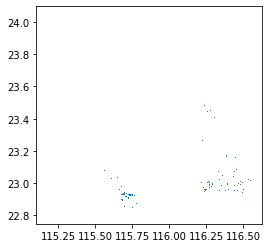

In [ ]:
ponds_sub[7388:15392].plot()

In [ ]:
ponds_test = ponds_sub.iloc[15391:15392]
ponds_test

,id,index_right,GID_0,NAME_0,geometry
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
ponds_test = (ponds_test.assign(mean19 = lambda gdf: float(xds.watermask.sel(time=2019).rio.clip(geometries = gdf.geometry, crs = 4326, all_touched=True).mean())))
ponds_test

,id,index_right,GID_0,NAME_0,geometry,mean19
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ...",0.333333


In [ ]:
#xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test.geometry, crs = 4326, all_touched=True)
#float(cropped.mean())

### Test on 2 ponds: Iterate over ponds for a specific year!

In [ ]:
# Option.A: Iterate over ponds for a specific year!
ponds_test2 = ponds_sub.iloc[15390:15392]
ponds_test2

,id,index_right,GID_0,NAME_0,geometry
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ..."
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
# Function to get pixel value by polygon
def getWaterCover(pond_index):
  wc_xda = xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test2.iloc[pond_index].geometry, crs = 4326, all_touched=True)
  wc_mean = wc_xda.mean()
  wc_scaled = int(float(wc_mean)*100)
  return wc_scaled

In [ ]:
#mean19 = [int(float(xds.watermask.sel(time=2019).rio.clip(geometries = ponds_test2.iloc[i].geometry, crs = 4326, all_touched=True).mean())*100) for i in range(len(ponds_test2))]
mean19 = [getWaterCover(i) for i in range(len(ponds_test2))]
mean19

/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


[100, 33]

In [ ]:
ponds_test2 = ponds_test2.assign(mean2019 = mean19)
ponds_test2

,id,index_right,GID_0,NAME_0,geometry,mean2019
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ...",100
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ...",33


In [ ]:
# Apply list comprehension in pandas dataframe: didn't work in my case!
#ponds_test2['mean19'] = ponds_test2.apply(lambda row: int(float(xds.watermask.sel(time=2019).rio.clip(geometries = row.geometry, crs = 4326, all_touched=True).mean())*100))

### Test on 2 ponds: Iterate over years

In [ ]:
ponds_test3 = ponds_sub.iloc[15390:15392]
ponds_test3

,id,index_right,GID_0,NAME_0,geometry
847507,901455,2,CHN,China,"MULTIPOLYGON (((115.79877 22.96507, 115.79877 ..."
847508,901456,2,CHN,China,"MULTIPOLYGON (((115.79877 22.80957, 115.79895 ..."


In [ ]:
# Function to get pixel value by polygon
def getWaterCover2(year, pond_index):
  wc_xda = xds.watermask.sel(time=year).rio.clip(geometries = ponds_test3.iloc[pond_index].geometry, crs = 4326, all_touched=True)
  wc_mean = wc_xda.mean()
  wc_scaled = int(float(wc_mean)*100)
  return wc_scaled

In [ ]:
#meanXX = [getWaterCover2(y, i) for y in t[-2:] for i in range(len(ponds_test3))]
#meanXX = [getWaterCover2(y,i) for y,i in zip(t[-2:], range(len(ponds_test3)))]
meanXX = [[getWaterCover2(y,i) for i in range(len(ponds_test3))] for y in t]
meanXX

/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:284: ShapelyDeprecationWarning: It

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 33],
 [100, 41],
 [100, 41],
 [100, 25],
 [100, 41],
 [100, 41],
 [100, 41],
 [100, 41],
 [0, 41],
 [100, 33],
 [100, 41],
 [0, 41],
 [0, 41],
 [100, 41],
 [100, 50],
 [0, 41],
 [100, 41],
 [100, 33],
 [100, 33],
 [100, 41],
 [100, 33]]

In [ ]:
meanXX[-1]

[100, 33]

In [ ]:
newcols = ['mean_'+str(y) for y in t]
print(newcols)
print(len(newcols))

['mean_1986', 'mean_1987', 'mean_1988', 'mean_1989', 'mean_1990', 'mean_1991', 'mean_1992', 'mean_1993', 'mean_1994', 'mean_1995', 'mean_1996', 'mean_1997', 'mean_1998', 'mean_1999', 'mean_2000', 'mean_2001', 'mean_2002', 'mean_2003', 'mean_2004', 'mean_2005', 'mean_2006', 'mean_2007', 'mean_2008', 'mean_2009', 'mean_2010', 'mean_2011', 'mean_2012', 'mean_2013', 'mean_2014', 'mean_2015', 'mean_2016', 'mean_2017', 'mean_2018', 'mean_2019']
34


In [ ]:
#ponds_test3_reindexed = ponds_test3.reindex(columns=ponds_test3.columns.tolist() + newcols)
#ponds_test3_reindexed

In [ ]:
#ponds_test3_reindexed = ponds_test3.assign(mean19 = meanXX[-1])
#ponds_test3_reindexed

### Test: Zonal Statistics using **`Rasterstats`**


In [ ]:
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings("ignore")

***For `zonal_stats` to work, make sure that*** <br>
* `array` is a 2D array;

* `transform` is written in this form:
1. top left easting or X coordinate
2. West-East pixel resolution
3. rotation (typically 0 if image is "north up")
4. top left northing or Y coordinate
5. rotation, (typically 0 if image is "north up")
6. North-South pixel resolution (typically -1 * W-E resolution)



In [ ]:
path_ponds = '/content/drive/My Drive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Aquaculture_ponds_Asian_coast_2019/ponds_by_parcel/'
pondItem = glob(os.path.join(path_ponds, '*11*'))
ponds = gpd.read_file(pondItem[0])
ponds.rename(columns={'id':'pondID'}, inplace=True)
#ponds_sub = [gpd.GeoDataFrame(ponds[ponds.geometry.within(i)]) for i in bbox]

ponds_test4 = ponds.iloc[9000:9050]
ponds_test4.rename(columns={'id':'pondID'}, inplace=True)
ponds_test4.head()

,pondID,parcel_number,distance,elevation,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,geometry
9000,894759,5171,4561.0,0,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28314 23.00002, 116.28332 ..."
9001,894761,5171,2598.0,3,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28323 22.98259, 116.28341 ..."
9002,894762,5171,27627.0,27,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.12_1,Shantou,"MULTIPOLYGON (((116.28332 23.21417, 116.28332 ..."
9003,894763,5171,27006.0,17,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28341 23.36087, 116.28350 ..."
9004,894764,5171,2032.0,2,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28323 22.97603, 116.28359 ..."


In [ ]:
xda_test = xds.sel(time=2019).to_array()
# Convert DataArray to numpy array
# https://stackoverflow.com/questions/55132416/converting-dataarray-into-numpy-array
array = xda_test.values[0]
array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Get "Affine transform"
# https://github.com/perrygeo/python-rasterstats/blob/master/docs/notebooks/Integrating%20with%20GeoPandas%20and%20Numpy.ipynb
transform = xda_test.rio.transform()
we_pr, rotation, ns_pr = transform[0], transform[1], transform[4]

x, y = xds.x.min().values, xds.y.max().values

transform = [x, we_pr, rotation, y, rotation, ns_pr]
transform

[array(114.25964051),
 0.00026949458523585647,
 0.0,
 array(24.62062107),
 0.0,
 -0.00026949458523585647]

In [ ]:
zonstats_1st = zonal_stats(ponds_test4, array, transform=transform, categorical=True, all_touched=False) 
print(zonstats_1st)

[{0: 1}, {0: 15, 1: 1}, {}, {1: 1}, {0: 3}, {1: 3}, {0: 21}, {0: 10}, {0: 2}, {0: 19, 1: 1}, {}, {1: 1}, {0: 27}, {0: 1}, {}, {0: 5}, {0: 4}, {1: 4}, {0: 5}, {0: 1}, {0: 9}, {0: 9}, {}, {0: 9}, {0: 4}, {0: 11}, {0: 10}, {0: 3}, {1: 1}, {0: 7}, {0: 11}, {}, {}, {0: 3}, {0: 3}, {0: 2}, {}, {0: 9}, {1: 1}, {0: 1}, {0: 12, 1: 12}, {1: 1}, {}, {0: 7}, {}, {}, {0: 10}, {0: 9}, {0: 9}, {0: 4}]


* **Add Zonal Statistics to Geodataframe**

In [ ]:
df_stats = pd.DataFrame(zonstats_1st)
# Convert data type of columns
# https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
df_stats = df_stats.convert_dtypes()
# Rename columns
df_stats.rename(columns={0:'c0_2019', 1:'c1_2019'}, inplace=True)
# Add 'pondID' as new column
df_stats = df_stats.assign(pondID = np.array(ponds_test4['pondID']))
df_stats[['c0_2019', 'c1_2019']] = df_stats[['c0_2019', 'c1_2019']].fillna(0)
#df_stats

In [ ]:
# Store needed Stats from Run 1 and Fetch Ponds for Run 2
stats_run1 = df_stats[(df_stats['c0_2019']!=0) | (df_stats['c1_2019']!=0)]
ponds_run2 = ponds_test4.merge(df_stats[(df_stats['c0_2019']==0) & (df_stats['c1_2019']==0)], how='right', on='pondID')
print(stats_run1.shape, ponds_run2.shape)

(40, 3) (10, 14)


In [ ]:
zonstats_2nd = zonal_stats(ponds_run2, array, transform=transform, categorical=True, all_touched=True) 
print(zonstats_2nd)

[{0: 1}, {0: 2}, {0: 1}, {0: 1}, {1: 4}, {0: 2}, {0: 1}, {0: 2}, {0: 2}, {1: 4}]


In [ ]:
df_stats = pd.DataFrame(zonstats_2nd)
df_stats = df_stats.convert_dtypes()
# Rename columns
df_stats.rename(columns={0:'c0_2019', 1:'c1_2019'}, inplace=True)
# Add 'pondID' as new column
df_stats = df_stats.assign(pondID = np.array(ponds_run2['pondID']))
df_stats[['c0_2019', 'c1_2019']] = df_stats[['c0_2019', 'c1_2019']].fillna(0)

stats_run2 = df_stats

In [ ]:
zonstats = pd.concat([stats_run1, stats_run2])
#ponds_zonstats = ponds_test4
#ponds_zonstats = ponds_zonstats.merge(zonstats, how='outer', on='pondID')
# https://stackoverflow.com/questions/53645882/pandas-merging-101

print(zonstats.shape)
zonstats.head()

(50, 3)


,c0_2019,c1_2019,pondID
0,1,0,894759
1,15,1,894761
3,0,1,894763
4,3,0,894764
5,0,3,894765


### Function: Zonal Statistics using **`Rasterstats`**

In [ ]:
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get "Affine Transformation" for rasters over one parcel
transform = xds.rio.transform()
we_pr, rotation, ns_pr = transform[0], transform[1], transform[4]
x, y = xds.x.min().values, xds.y.max().values
transform = [x, we_pr, rotation, y, rotation, ns_pr]
transform

[array(114.25964051),
 0.00026949458523585647,
 0.0,
 array(24.62062107),
 0.0,
 -0.00026949458523585647]

In [ ]:
ponds_test5 = ponds.iloc[9020:9040]
ponds_test5.rename(columns={'id':'pondID'}, inplace=True)
ponds_test5.head()

,pondID,parcel_number,distance,elevation,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,geometry
9020,894784,5171,857.0,1,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28368 22.96525, 116.28422 ..."
9021,894785,5171,5901.0,1,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28368 23.01277, 116.28422 ..."
9022,894786,5171,2258.0,4,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 22.97810, 116.28422 ..."
9023,894787,5171,4798.0,2,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28377 23.00271, 116.28431 ..."
9024,894788,5171,5802.0,3,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 23.01196, 116.28431 ..."


In [ ]:
def tidy_zonstats_df(zonstats_dict, gdf, year):
  # Tidy dataframe of zonal statistics
  df_stats = pd.DataFrame(zonstats_dict)
  # Convert values to proper data type
  df_stats = df_stats.convert_dtypes()
  # Rename columns
  df_stats.rename(columns={0:'c0_'+str(year), 1:'c1_'+str(year)}, inplace=True)
  # Add 'pondID' as new column
  df_stats = df_stats.assign(pondID = np.array(gdf['pondID']))
  df_stats[['c0_'+str(year), 'c1_'+str(year)]] = df_stats[['c0_'+str(year), 'c1_'+str(year)]].fillna(0)
  return df_stats


def zonal_statistics(year, gdf):

  # Subset raster to one year
  xda_1Y = xds.sel(time=year).to_array()
  # Convert DataArray to NumpyArray
  array = xda_1Y.values[0]

  # 1st Run Zonal statistics
  zonstats_1st = zonal_stats(gdf, array, transform=transform, categorical=True, all_touched=False) 

  # Tidy dataframe of zonal statistics
  df_stats = tidy_zonstats_df(zonstats_1st, gdf, year)

  # Store needed Stats from Run 1 and Fetch Ponds for Run 2
  stats_run1 = df_stats[(df_stats['c0_'+str(year)]!=0) | (df_stats['c1_'+str(year)]!=0)]
  ponds_run2 = gdf.merge(df_stats[(df_stats['c0_'+str(year)]==0) & (df_stats['c1_'+str(year)]==0)], how='right', on='pondID')

  # 2nd Run Zonal Stats
  zonstats_2nd = zonal_stats(ponds_run2, array, transform=transform, categorical=True, all_touched=True)

  # Tidy dataframe of zonal statistics
  stats_run2 = tidy_zonstats_df(zonstats_2nd, ponds_run2, year) 

  # Join Outputs
  zonstats = pd.concat([stats_run1, stats_run2])

  return zonstats
  

In [ ]:
years = xds.time.values[-1:]
zonstats_list = [zonal_statistics(i, ponds_test5) for i in years]
zonstats = pd.concat([df.set_index('pondID') for df in zonstats_list], axis=1)
ponds_zonstats = ponds_test5.merge(zonstats, how='outer', on='pondID')
ponds_zonstats

,pondID,parcel_number,distance,elevation,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,geometry,c0_2019,c1_2019
0,894784,5171,857.0,1,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28368 22.96525, 116.28422 ...",9,0
1,894785,5171,5901.0,1,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28368 23.01277, 116.28422 ...",9,0
2,894786,5171,2258.0,4,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 22.97810, 116.28422 ...",1,0
3,894787,5171,4798.0,2,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28377 23.00271, 116.28431 ...",9,0
4,894788,5171,5802.0,3,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 23.01196, 116.28431 ...",4,0
5,894789,5171,699.0,3,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28404 22.96417, 116.28440 ...",11,0
6,894790,5171,4914.0,3,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 23.00379, 116.28440 ...",10,0
7,894791,5171,12026.0,19,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28404 23.06865, 116.28440 ...",3,0
8,894792,5171,28326.0,5,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28404 23.30787, 116.28440 ...",0,1
9,894793,5171,540.0,2,CHN,China,CHN.6_1,Guangdong,Province,CHN.6.8_1,Jieyang,"MULTIPOLYGON (((116.28422 22.96247, 116.28458 ...",7,0


## Export GEE Map to html / image